<a href="https://colab.research.google.com/github/developer-onizuka/MachineLearningOnAWS/blob/main/BERT_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 目的

・Transformer (Attention is All you needに示されるAttention機構)の概要を理解する。<br>
・Pipelineを使って、任意のモデルで推論を行う。<br>
・BERTと呼ばれるエンコーダー型のモデルを使い、分類器を作る。(Fine Tuning)

## 2. Transformerについて

## 2-1. 従来モデルの問題点

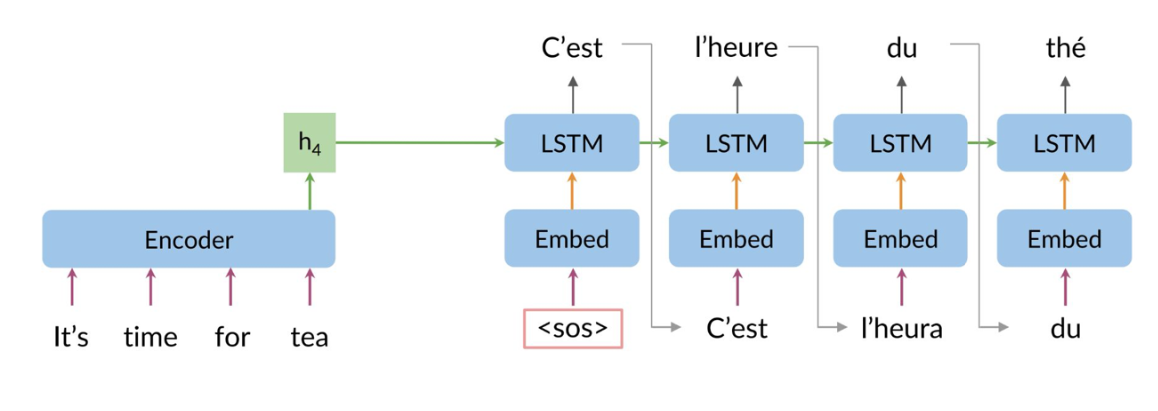

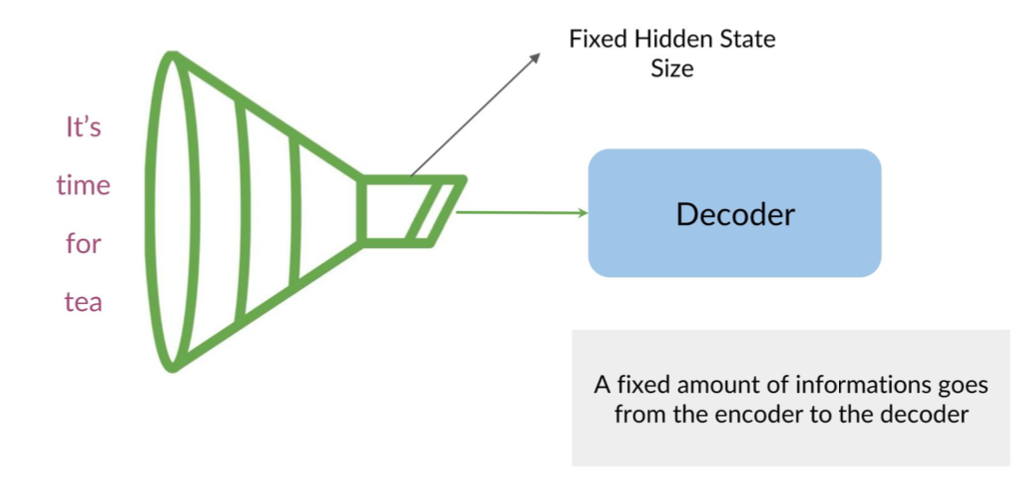

## 2-2. Attention機構

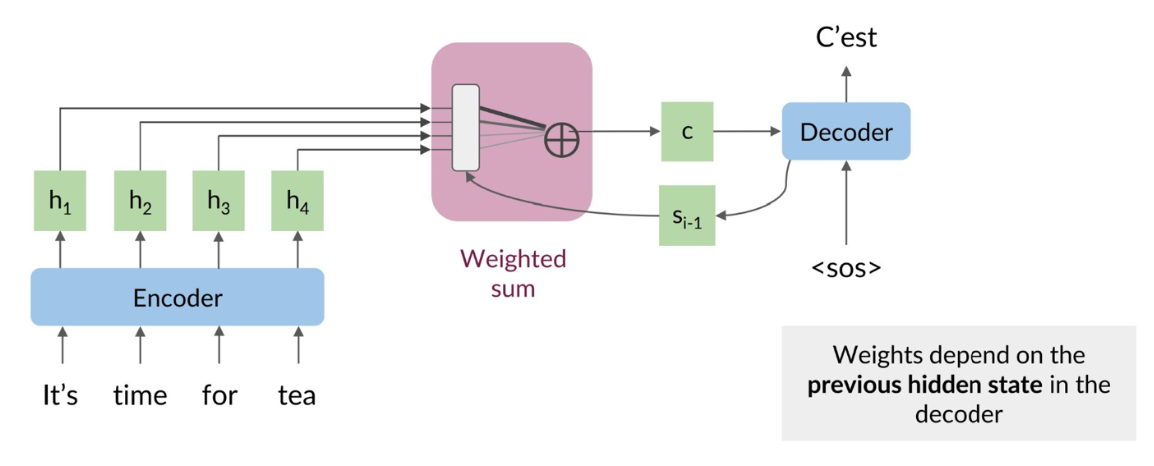

## 2-3. Transformerのブロック図

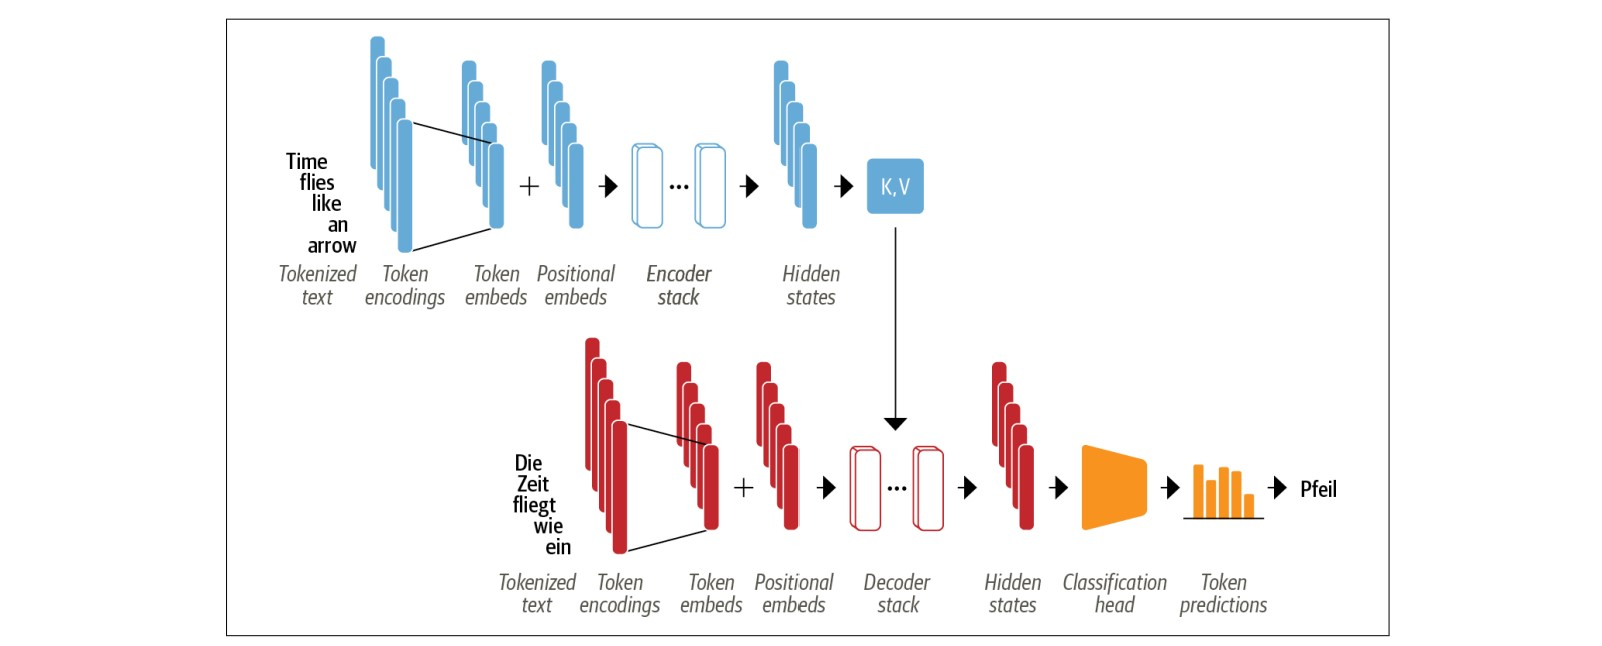

| 用語 (Japanese) | 用語 (English) | 説明 (Japanese) |
|----------------|----------------|----------------|
| **トークン化されたテキスト** | **Tokenized text** | 入力テキストは最初にトークン化され、単語やサブワードに分割されます。 |
| **トークンのエンコーディング** | **Token encodings** | 各トークンには一意のエンコーディングが割り当てられます。<br>このエンコーディングは、トークンの意味とシーケンス内での位置を表します。 |
| **トークンの埋め込み** | **Token Embedding** | トークンのエンコーディングは、トークン埋め込み層を通過します。<br>この層は、エンコーディングをベクトル表現に変換し、トランスフォーマーモデルで使用できるようにします。 |
| **位置埋め込み** | **Positional Embedding** | 位置埋め込み層は、トークン埋め込みに位置情報を加えます。<br>この情報は、シーケンス内の各トークンの位置を表します。 |
| **エンコードスタック** | **Encode Stack** | トークン埋め込みと位置埋め込みは、エンコーダ層のスタックを通過します。<br>各エンコーダ層は自己注意の仕組みを適用します。<br>自己注意機構により、モデルはシーケンスの異なる部分間の長距離依存関係を学習できます。 |
| **隠れ状態** | **Hidden States** | エンコードスタックの出力は、一連の隠れ状態となります。<br>これらの隠れ状態は、入力シーケンスの表現を示します。 |
| **デコードスタック** | **Decoder Stack** | 隠れ状態はデコーダ層のスタックを通過します。<br>デコーダ層は自己注意機構と、入力シーケンスに注意を向けるアテンション機構を適用します。<br>アテンション機構により、モデルは出力シーケンスを生成する際に、入力シーケンスの異なる部分に焦点を当てることができます。 |
<br>

## 2-4. エンコーダー、デコーダー機能の特徴

| 分類 | 主なモデル | 主な用途 |
|-------------|-----|------------------------------|
| **Encoder-Decoder Models** | BART, T5 | 機械翻訳、テキスト要約、データ生成、コード補完 |
| **Encoder-Only Models** | BERT, RoBERTa, DistilBERT | 文書分類、固有表現抽出、検索システム、文書埋め込み |
| **Decoder-Only Models** | GPT, GPT-2, GPT-3, LLaMA | テキスト生成、対話型AI、コード生成、文章補完 |


## 3. ライブラリのインストール

In [ ]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install seaborn --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

## 4. Hugging Faceを使った推論実行

## 4-1. Text Classification

In [ ]:
!pip install -U transformers
!pip install -U sentencepiece
!pip install -U sacremoses

In [ ]:
from transformers import pipeline
import pandas as pd

In [ ]:
classifier = pipeline("text-classification", model = "SamLowe/roberta-base-go_emotions")

text = "wow! we have come across this far"
outputs = classifier(text)
pd.DataFrame(outputs)

## 4-2. Question Answering

In [ ]:
text = """
Dear Amazon, last week I ordered an Optimus Prime action figure from your
online store in India. Unfortunately when I opened the package, I discovered to
my horror that I had been sent an action figure of Megatron instead!
"""

reader = pipeline("question-answering")
question = "from where did I placed order?"

outputs = reader(question=question, context=text)
pd.DataFrame([outputs])

## 4-3. Translation

In [ ]:
translator = pipeline("translation_en_to_de", model="Helsinki-NLP/opus-mt-en-de")

outputs = translator(text)
outputs

## 4-4. Text Generation

In [ ]:
from transformers import set_seed
set_seed(0)

In [ ]:
text

In [ ]:
generator = pipeline("text-generation", model="gpt2-large")

response = "I am sorry to hear that your order was mixed up"

# prompt = "user: " + text.replace("\n", " ") + " Customer Service Response: " + response

prompt = "There was a lion "
outputs = generator(prompt, max_length=128)

In [ ]:
outputs

## 5. Hugging Faceを使ったFine Tuning

## 5-1. データエンジニアリング

In [ ]:
import pandas as pd

df = pd.read_parquet("https://datasets-documentation.s3.eu-west-3.amazonaws.com/amazon_reviews/amazon_reviews_2010.snappy.parquet",columns=["star_rating","review_body"])


In [ ]:
for i in range(1,6):
    print("star_rating: ", i)
    print(df[df['star_rating'] == i].count())
    print('-------------------------')

star_rating:  1
star_rating    382315
review_body    382315
dtype: int64
-------------------------
star_rating:  2
star_rating    222957
review_body    222957
dtype: int64
-------------------------
star_rating:  3
star_rating    333851
review_body    333851
dtype: int64
-------------------------
star_rating:  4
star_rating    735597
review_body    735597
dtype: int64
-------------------------
star_rating:  5
star_rating    2193752
review_body    2193752
dtype: int64
-------------------------


In [ ]:
for i in range(1,6):
    new_df = 'df' + str(i)
    globals()[new_df] = df[df['star_rating'] == i].sample(n=2000)

In [ ]:
df = pd.concat([df1,df2,df3,df4,df5])
df.count()

,0
star_rating,10000
review_body,10000


In [ ]:
df['review_body'] = df['review_body'].astype(str)
df['star_rating'] = df['star_rating'].astype("int64")

In [ ]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 3340915 to 1539821
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   star_rating  10000 non-null  int64 
 1   review_body  10000 non-null  object
dtypes: int64(1), object(1)
memory usage: 234.4+ KB


,0
star_rating,0
review_body,0


In [ ]:
df['review_body']

,review_body
3340915,just got my ring and the 3 stones init are not...
418919,I ordered the trilogy here on Amazon after pre...
2061372,I just finished The Big Short a few minutes ag...
466731,These toys are cute but yet while my chihuahua...
3269976,This book was $25. and looked to be copied fro...
...,...
2480113,Great experience in cold weather and with heav...
1421166,I dare you. I triple dare you. Those of you ...
2770779,I bought this specifically for a Windows 7 sys...
2458325,I own three small dogs and every time someone ...


In [ ]:
df = df.rename(columns={'review_body': 'text', 'star_rating': 'label'})

In [ ]:
df['text']

,text
3340915,just got my ring and the 3 stones init are not...
418919,I ordered the trilogy here on Amazon after pre...
2061372,I just finished The Big Short a few minutes ag...
466731,These toys are cute but yet while my chihuahua...
3269976,This book was $25. and looked to be copied fro...
...,...
2480113,Great experience in cold weather and with heav...
1421166,I dare you. I triple dare you. Those of you ...
2770779,I bought this specifically for a Windows 7 sys...
2458325,I own three small dogs and every time someone ...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 3340915 to 1539821
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   10000 non-null  int64 
 1   text    10000 non-null  object
dtypes: int64(1), object(1)
memory usage: 234.4+ KB


In [ ]:
df['label'].value_counts()

,count
label,
1,2000
2,2000
3,2000
4,2000
5,2000


In [ ]:
df["label"] = df["label"] - 1

In [ ]:
import matplotlib.pyplot as plt

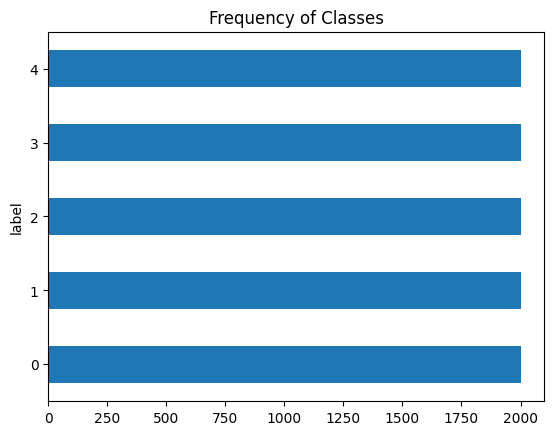

In [ ]:
label_counts = df['label'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

## 5-2. トークナイザーの定義

In [ ]:
from transformers import AutoTokenizer

base_model = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(base_model)

text = "This product is very good."
encoded_text = tokenizer(text)
print(encoded_text)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

{'input_ids': [101, 1188, 3317, 1110, 1304, 1363, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


## 5-3. データセットの分割

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'])
test_df, validation_df = train_test_split(test_df, test_size=0.5, stratify=test_df['label'])

train_df.shape, test_df.shape, validation_df.shape

((8000, 2), (1000, 2), (1000, 2))

In [ ]:
from datasets import Dataset, DatasetDict, Features, Value, ClassLabel

dataset = DatasetDict({
    'train': Dataset.from_pandas(train_df, preserve_index=False),
    'test': Dataset.from_pandas(test_df, preserve_index=False),
    'validation': Dataset.from_pandas(validation_df, preserve_index=False)
})

dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 1000
    })
})

In [ ]:
dataset['train'].features

{'label': Value(dtype='int64', id=None),
 'text': Value(dtype='string', id=None)}

In [ ]:
dataset['train']['label'][:10]

[3, 2, 0, 0, 0, 0, 4, 2, 0, 1]

## 5-4. データセットのトークン化

In [ ]:
def tokenize(temp):
    result = tokenizer(temp['text'], padding=True, truncation=True)
    return result

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 1422, 1797, 3055, 1454, 124, 1105, 1460, 170, 188, 2528, 26950, 1111, 1123, 5913, 1177, 146, 1458, 170, 10815, 1105, 21910, 1111, 1123, 1106, 4330, 1315, 119, 1153, 1144, 170, 1415, 1246, 1177, 146, 1225, 170, 1974, 1104, 1844, 1113, 9786, 1112, 1242, 1104, 1103, 4321, 118, 16777, 1216, 1112, 1142, 2694, 1103, 10815, 1108, 1113, 1103, 1353, 1334, 119, 1188, 1110, 3264, 1105, 1131, 7871, 3351, 1103, 2072, 1383, 1112, 1122, 2075, 1241, 5656, 1105, 9007, 21910, 1315, 119, 1109, 3945, 1108, 1145, 1632, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 146, 1400, 170, 1714, 6876, 1104, 1292, 12237, 1107, 1103, 6346, 170, 1229, 1171, 117, 1105, 3055, 1400, 170, 2640, 1106, 2222, 1172, 1149, 119, 1220, 1250, 10899, 119, 1220, 4218, 1089

In [ ]:
review_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

## 5-5. ラベルのマッピング

In [ ]:
# label2id, id2label
label2id = {'Excellent' : 4, 'Good' : 3, 'Average' : 2, 'Below Average' : 1, 'Poor' : 0}
id2label = {v:k for k,v in label2id.items()}

label2id, id2label

({'Excellent': 4, 'Good': 3, 'Average': 2, 'Below Average': 1, 'Poor': 0},
 {4: 'Excellent', 3: 'Good', 2: 'Average', 1: 'Below Average', 0: 'Poor'})

## 5-6. モデル構築

In [ ]:
from transformers import AutoModel
import torch

In [ ]:
base_model

'bert-base-cased'

In [ ]:
model = AutoModel.from_pretrained(base_model)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
model.config.id2label

{0: 'LABEL_0', 1: 'LABEL_1'}

In [ ]:
model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## 5-7. 分類器を使ったFine Tuning

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoConfig

num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(base_model, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(base_model, config=config).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Poor",
    "1": "Below Average",
    "2": "Average",
    "3": "Good",
    "4": "Excellent"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Average": 2,
    "Below Average": 1,
    "Excellent": 4,
    "Good": 3,
    "Poor": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
from transformers import TrainingArguments

batch_size = 32
training_dir = "bert_base_train_dir"
gradient_accumulation_steps = 2

training_args = TrainingArguments(
    output_dir=training_dir,
    overwrite_output_dir = True,
    run_name = 'experiment_v1',
    num_train_epochs = 1,
    learning_rate = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    weight_decay = 0.01,
    eval_strategy = 'no', #'epoch',
    disable_tqdm = False,
    report_to = 'none'
)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}

## 5-8. モデルの学習

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model, args=training_args,
    compute_metrics=compute_metrics,
    train_dataset = review_encoded['train'],
    eval_dataset = review_encoded['validation'],
    tokenizer = tokenizer
)

<ipython-input-43-ecfbe759161c>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=250, training_loss=1.2820849609375, metrics={'train_runtime': 751.4357, 'train_samples_per_second': 10.646, 'train_steps_per_second': 0.333, 'total_flos': 2104945139712000.0, 'train_loss': 1.2820849609375, 'epoch': 1.0})

## 5-9. モデルの評価

In [ ]:
preds_output = trainer.predict(review_encoded['test'])
preds_output.metrics

{'test_loss': 1.1016895771026611,
 'test_accuracy': 0.521,
 'test_f1': 0.50896805898756,
 'test_runtime': 32.4963,
 'test_samples_per_second': 30.773,
 'test_steps_per_second': 0.985}

In [ ]:
import numpy as np
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = review_encoded['test'][:]['label']

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.68      0.62       200
           1       0.46      0.51      0.49       200
           2       0.46      0.35      0.40       200
           3       0.46      0.33      0.38       200
           4       0.59      0.74      0.66       200

    accuracy                           0.52      1000
   macro avg       0.51      0.52      0.51      1000
weighted avg       0.51      0.52      0.51      1000



In [ ]:
label2id

{'Excellent': 4, 'Good': 3, 'Average': 2, 'Below Average': 1, 'Poor': 0}

In [ ]:
# plot confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

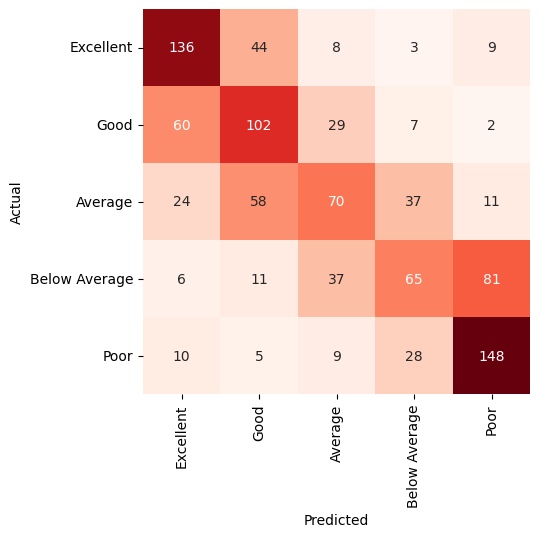

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt='d', cbar=False, cmap='Reds')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

## 5-10. モデルの保存

In [ ]:
trainer.save_model("bert-base-uncased-amazon-review-model")

## 5-11. モデルの推論試行

In [ ]:
# use pipeline for prediciton
from transformers import pipeline

classifier = pipeline('text-classification', model= 'bert-base-uncased-amazon-review-model')

classifier("I like this toy. I recommned this to my friends!")



Device set to use cuda:0


[{'label': 'Excellent', 'score': 0.7498204708099365}]

In [ ]:
classifier("Disapointed")

[{'label': 'Poor', 'score': 0.492951899766922}]